In [1]:
import numpy as np

import os
import subprocess

import webbpsf

from synphot import SourceSpectrum
import stsynphot

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats,SigmaClip
from astropy.wcs import WCS
from astropy.convolution import interpolate_replace_nans,Gaussian2DKernel,Gaussian1DKernel


from skimage.draw import line,circle_perimeter, circle_perimeter_aa
from skimage.measure import profile_line

from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,zoomed_inset_axes)
from photutils.centroids import (centroid_1dg, centroid_2dg,centroid_com, centroid_quadratic, centroid_sources)
from photutils.background import Background2D, MedianBackground
from photutils.profiles import RadialProfile
from photutils.segmentation import detect_sources#, make_source_mask

from scipy.ndimage import shift, rotate, gaussian_filter
from scipy.signal import find_peaks, find_peaks_cwt

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


#### Set the WebbPSF path 

In [ ]:
# if os.environ.get('WEBBPSF_PATH', None) is None:
#     #Set Webb PSF Path
#     os.environ['WEBBPSF_PATH'] = '/Users/emmalieb/WR140Paper/WEBBPSF_PATH/'
# print(os.environ.get('WEBBPSF_PATH'))

#### Define global variables for your data files 
These will depend on how you've named your data.

In [22]:
cycle = '1349058001'
dither = "01"
filt = "F770W"

colormap = "cubehelix"

#### Open the Uncalibrated data 
Find the center of the first frame of the uncalibrated image. This will serve as the initial guess for the centroiding function for the level 2 data

(1024, 1032)
(array([416]), array([743]))


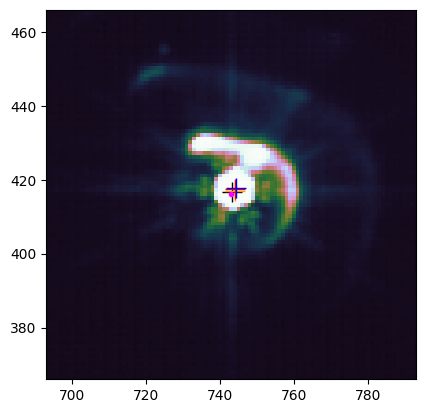

In [27]:
uncal_filename = "/Users/emmalieb/WR140Paper/Cycle1_stage1_uncal/jw0"+cycle+"_"+filt+"_000"+dither+"_mirimage_uncal.fits"
uncal_img = fits.getdata(uncal_filename, 1)
uncal_img = uncal_img[0,0,:,:]
print(uncal_img.shape)

plt.imshow(uncal_img, origin = "lower", cmap = colormap)#, norm = un_norm)
yinit, xinit = np.where(uncal_img==np.max(uncal_img[400:700,600:780]))

xycen1 = centroid_sources(uncal_img, xinit, yinit, box_size=11,centroid_func=centroid_com)
xycen2 = centroid_sources(uncal_img, xinit, yinit, box_size=11,centroid_func=centroid_quadratic)
xycen3 = centroid_sources(uncal_img, xinit, yinit, box_size=11,centroid_func=centroid_1dg)
xycen4 = centroid_sources(uncal_img, xinit, yinit, box_size=11,centroid_func=centroid_2dg)
xycens = [xycen1, xycen2, xycen3, xycen4]

marker = '+'
ms, mew = 15, 1

colors = ('black', 'orange', 'red', 'blue')
for xycen, color in zip(xycens, colors):
    plt.plot(*xycen, color=color, marker=marker, ms=ms, mew=mew)
print(np.where(uncal_img==np.max(uncal_img)))
plt.plot(xinit,yinit, color = "magenta", marker = '.')
plt.xlim(xinit-50,xinit+50)
plt.ylim(yinit-50,yinit+50)

x_init,y_init = xycen3
print(x_init,y_init)

Set DATE-AVG to '2022-07-27T15:38:56.244' from MJD-AVG.
Set DATE-END to '2022-07-27T15:39:55.907' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.880874 from OBSGEO-[XYZ].
Set OBSGEO-H to 1712778697.363 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


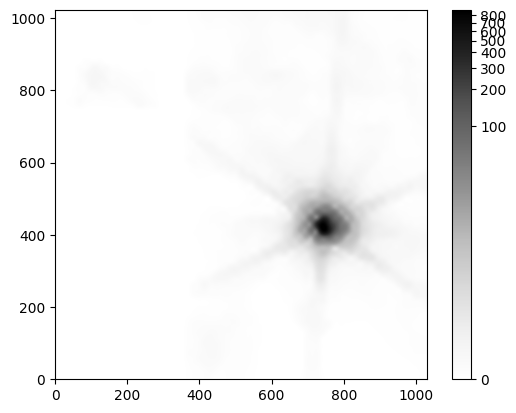

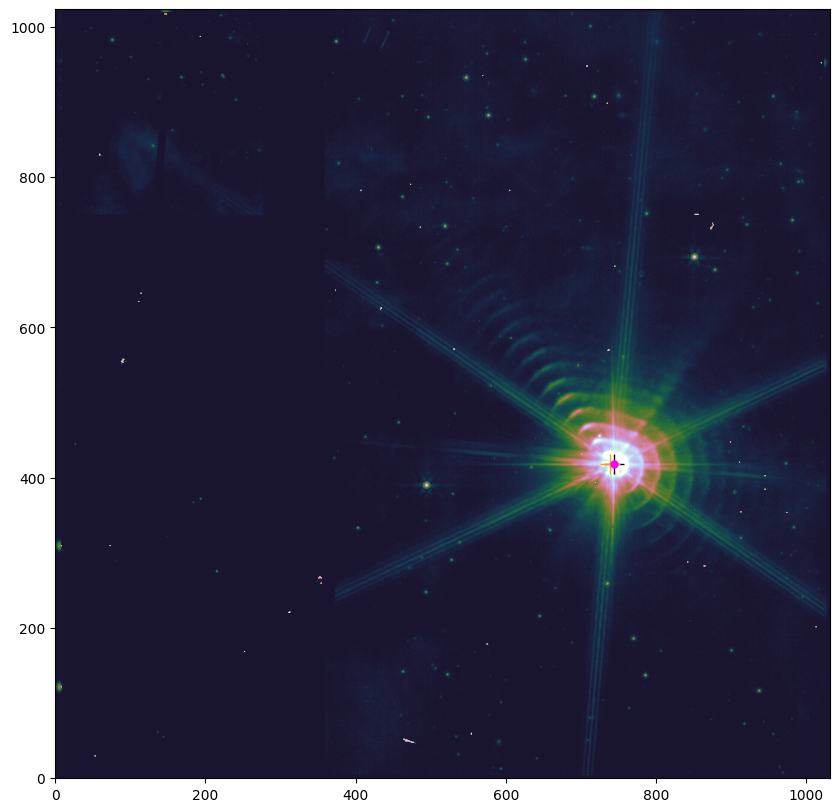

In [29]:
filename = '/Users/emmalieb/WR140Paper/pipeline_rerun_Cycle1 copy/jw0'+cycle+'_'+filt+'_000'+dither+'_mirimage_cal.fits'#'/Users/emmalieb/WR140Paper/Cycle2_'+filt+'_stag2b_dith1/jw03823004001_'+filt+'_00001_mirimage_i2d.fits'#'/Users/emmalieb/WR140Paper/Cycle1_F770W_stage2b/jw01349058001_07101_000'+dither+'_mirimage_cal.fits'
WR140 = fits.open(filename)
header1 = WR140[1].header
WR140data = WR140[1].data
_,med,std = sigma_clipped_stats(WR140data, mask_value = 0.0)

wcsWR140Im = WCS(WR140[1].header)

delt=400
image = WR140data - med
image[np.isnan(image)] = np.nan
image[image<0] = 0

gauss = Gaussian2DKernel(x_stddev=3,y_stddev=3)
result = interpolate_replace_nans(image, gauss)

sigma_clip = SigmaClip(sigma = 3)
bkg_estimator = MedianBackground()
bkg = Background2D(result, (15, 15),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkgnorm = simple_norm(bkg.background, 'log', min_cut =  np.min(bkg.background), max_cut = np.max(bkg.background))

plt.imshow(bkg.background, origin = "lower", cmap = "Greys", norm = bkgnorm)
plt.colorbar()
plt.show()
fig = plt.figure(figsize = (10,10))
norm = simple_norm(result, 'log', min_cut =  -1.0, max_cut = 1000.)
plt.imshow(result, norm = norm, origin = "lower", cmap = colormap)

xycen1 = centroid_sources(result, x_init, y_init, box_size=15,centroid_func=centroid_com)
xycen2 = centroid_sources(result, x_init, y_init, box_size=15,centroid_func=centroid_quadratic)
xycen3 = centroid_sources(result, x_init, y_init, box_size=15,centroid_func=centroid_1dg)
xycen4 = centroid_sources(result, x_init, y_init, box_size=15,centroid_func=centroid_2dg)

xycens = [xycen1, xycen2]

marker = '+'
ms, mew = 15, 1

colors = ('black', 'orange', 'red', 'blue')
for xycen, color in zip(xycens, colors):
    plt.plot(*xycen, color=color, marker=marker, ms=ms, mew=mew)

plt.plot(x_init, y_init, color="magenta", marker=".", ms=10, mew=1)
cx,cy = xycen1


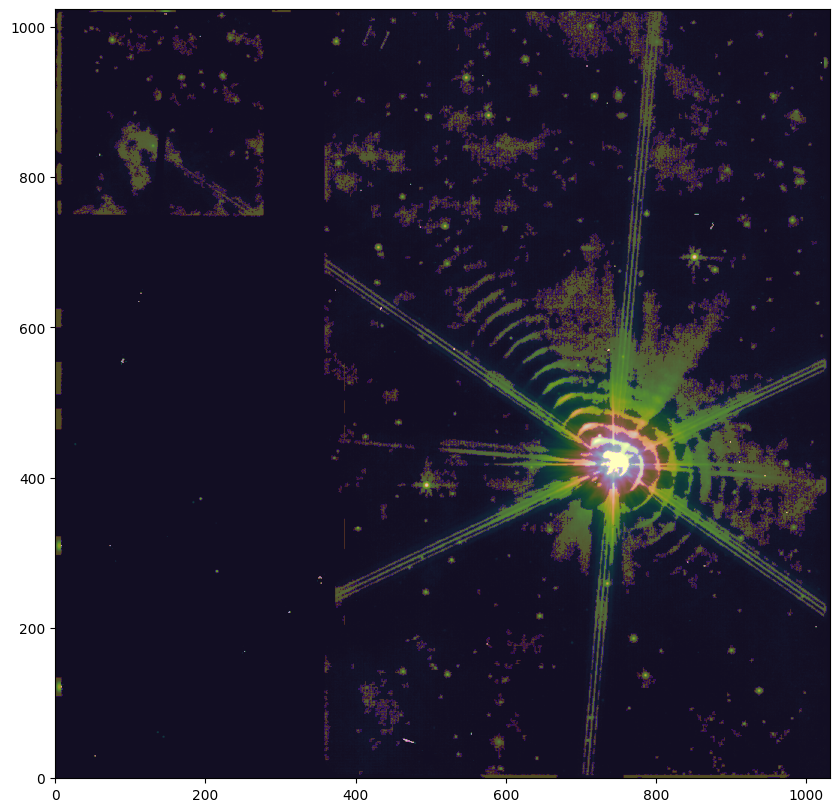

In [35]:
threshold = 3 * bkg.background_rms
segment_map = detect_sources(result, threshold, npixels=10, connectivity = 8)
mask = segment_map.make_source_mask()
fig = plt.figure(figsize = (10,10))
plt.imshow(mask, origin='lower',cmap = "gnuplot")#, alpha = 0.5)
norm = simple_norm(result, 'log', min_cut =  -1.0, max_cut = 1000.)
plt.imshow(result, norm = norm, origin = "lower", cmap = colormap, alpha = 0.75)

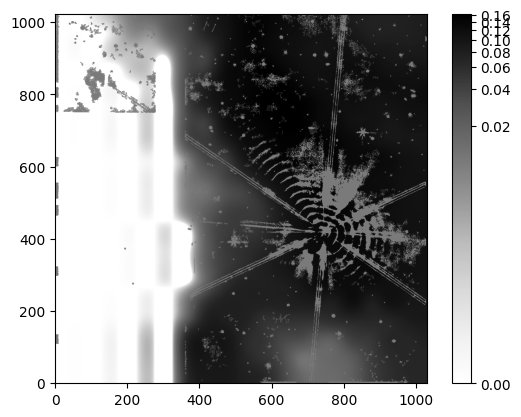

In [39]:
bkg_new = Background2D(result, (50, 50), coverage_mask = mask,fill_value = 0.01, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkgnorm_new = simple_norm(bkg_new.background, 'log', min_cut =  np.min(bkg_new.background), max_cut = np.max(bkg_new.background))
plt.imshow(bkg_new.background, origin = "lower", cmap = "Greys", norm = bkgnorm_new)
plt.colorbar()

In [40]:
result-=bkg_new.background #only run this cell once !!!!

In [41]:
# inst = webbpsf.setup_sim_to_match_file(filename)

# # psf_center = (int(cx), int(cy))

# boxsize = 1300

# # inst.detector_position = psf_center  

# sim_psf = inst.calc_psf("WR140_"+filt+"_psf.fits",fov_pixels = boxsize, display = True,overwrite = True, nlambda = 30)

# # psf = sim_psf[1].data

[[561 758]
 [354 613]
 [340 867]
 [336 864]]


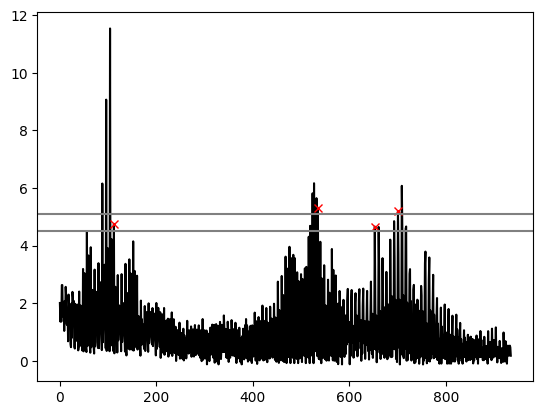

In [43]:
in_circ_x, in_circ_y = circle_perimeter(int(cy),int(cx),radius = 145, method = 'andres') #150
in_coords = list(zip(in_circ_x,in_circ_y))
in_circle_coords = np.array(list(zip(in_circ_x,in_circ_y)))
in_circ_prof = []
min_height = 4.0*np.std(result[in_circ_x,in_circ_y]) #770: 3.8
max_height = 4.75*np.std(result[in_circ_x,in_circ_y]) #770: 4.5
in_peaks,_ = find_peaks(result[in_circ_x,in_circ_y],height = (min_height, max_height), distance =30)#distance=30) 

spike_x = in_circ_x[in_peaks]
spike_y = in_circ_y[in_peaks]
in_spike_coords = in_circle_coords[in_peaks]
print(in_spike_coords)

plt.plot(result[in_circ_x,in_circ_y], color = "black")
plt.plot(in_peaks,result[spike_x,spike_y], 'x', color = "red")
plt.axhline(4*np.std(result[in_circ_x,in_circ_y]), c = "grey")
plt.axhline(4.5*np.std(result[in_circ_x,in_circ_y]), c = "grey")
plt.show()

1032 1024
[744.4225706] [417.75385602]


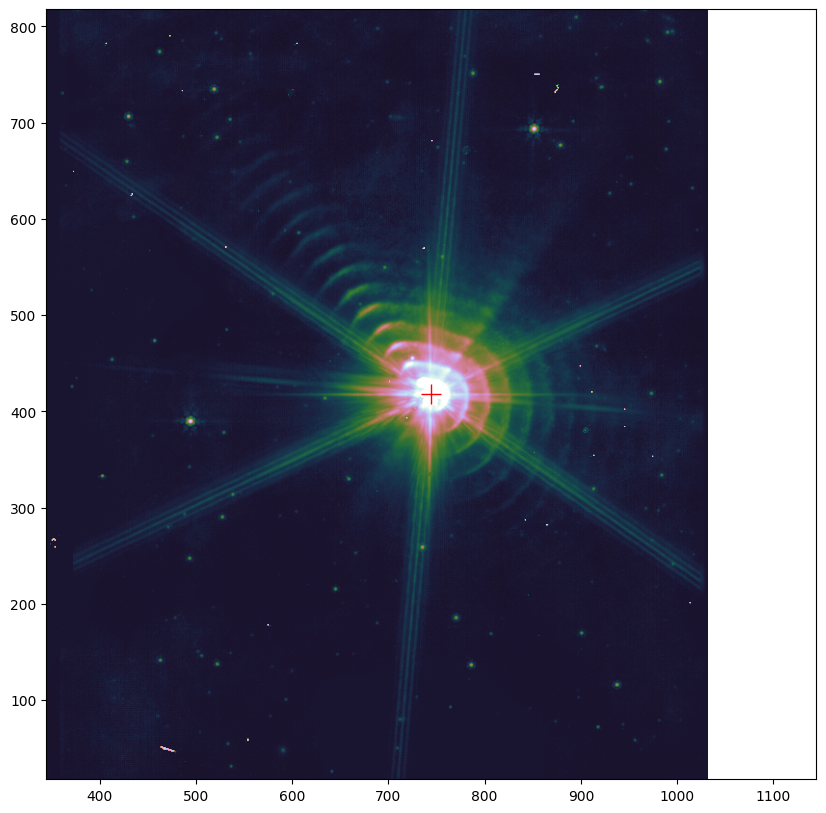

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()

y_shape, x_shape = np.shape(result)
print(x_shape, y_shape)

WRplot = ax.imshow(result, origin = 'lower',norm=norm, cmap = colormap)
print(cx,cy)

bdelt =400

x1, x2, y1, y2 = cx-bdelt, cx+bdelt, cy-bdelt,cy+bdelt
ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)
 
for in_coord in in_spike_coords:
    plt.plot(in_coord[1], in_coord[0], color = "magenta",marker="+", ms=15, mew=1)

circle2 = plt.Circle((cx, cy), 150, color='b', fill=False)

ax.add_patch(circle2) 

plt.plot(cx,cy, color="red", marker="+", ms=15, mew=1)

# plt.savefig("/Users/emmalieb/WR140Paper/stage2_pipererun_images/Wr140_"+filt+"_stage2_cycle2_dither"+dither+"_2dgcentroid.pdf", dpi = 300)
plt.show()
plt.close(fig)


In [45]:
psffilename = '/Users/emmalieb/WR140Paper/WR140_'+filt+'_psf.fits'
psffits = fits.open(psffilename)
header_psf = psffits[1].header
psf = psffits[3].data #<------want ext 3

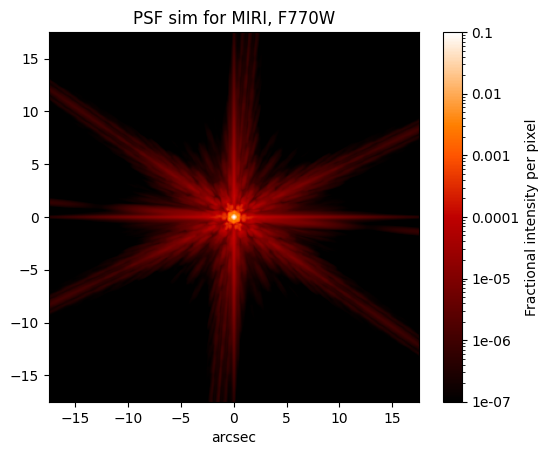

In [46]:
webbpsf.display_psf(psffits, ext=3, imagecrop = 35)

649.5023405448761 649.4923408033986


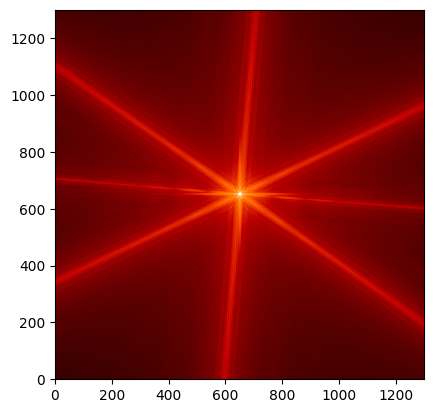

In [47]:
pcx,pcy = centroid_2dg(psf)
print(pcx,pcy)
norm_psf = psf/np.max(psf)

vmax = np.max(psf)
vmin = np.min(psf)

psf_cmap = "gist_heat"

plt.imshow(norm_psf , origin = "lower",cmap=psf_cmap, norm = matplotlib.colors.LogNorm(vmin, vmax))

bdelt = 400
plt.xlim(0, 1300)
plt.ylim(0, 1300)

marker = '+'
ms, mew = 15, 1.0

plt.plot(pcx,pcy, color="cyan", marker=marker, ms=ms, mew=mew)
plt.plot(cx,cy, color="yellow", marker=marker, ms=ms, mew=mew)

# plt.savefig("psf_model.pdf", dpi = 300)
# plt.close(fig)

In [49]:
def create_circular_mask(X,Y, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(X/2), int(Y/2))
    X, Y = np.ogrid[:X, :Y]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    print(dist_from_center)
    mask = dist_from_center <= radius
    return mask

X,Y = norm_psf.shape[:2]
mask = create_circular_mask(X,Y,None, radius = 10)
norm_psf[mask] = 0

[[919.23881554 918.53198093 917.82569151 ... 917.11994853 917.82569151
  918.53198093]
 [918.53198093 917.82460198 917.11776779 ... 916.41147963 917.11776779
  917.82460198]
 [917.82569151 917.11776779 916.41038842 ... 915.70355465 916.41038842
  917.11776779]
 ...
 [917.11994853 916.41147963 915.70355465 ... 914.99617486 915.70355465
  916.41147963]
 [917.82569151 917.11776779 916.41038842 ... 915.70355465 916.41038842
  917.11776779]
 [918.53198093 917.82460198 917.11776779 ... 916.41147963 917.11776779
  917.82460198]]


[94.92023006] [-231.73848478]
[10.44122531] [-25.49123333]
[344.4225706] [1144.4225706] [17.75385602] [817.75385602]
(1024, 1032)


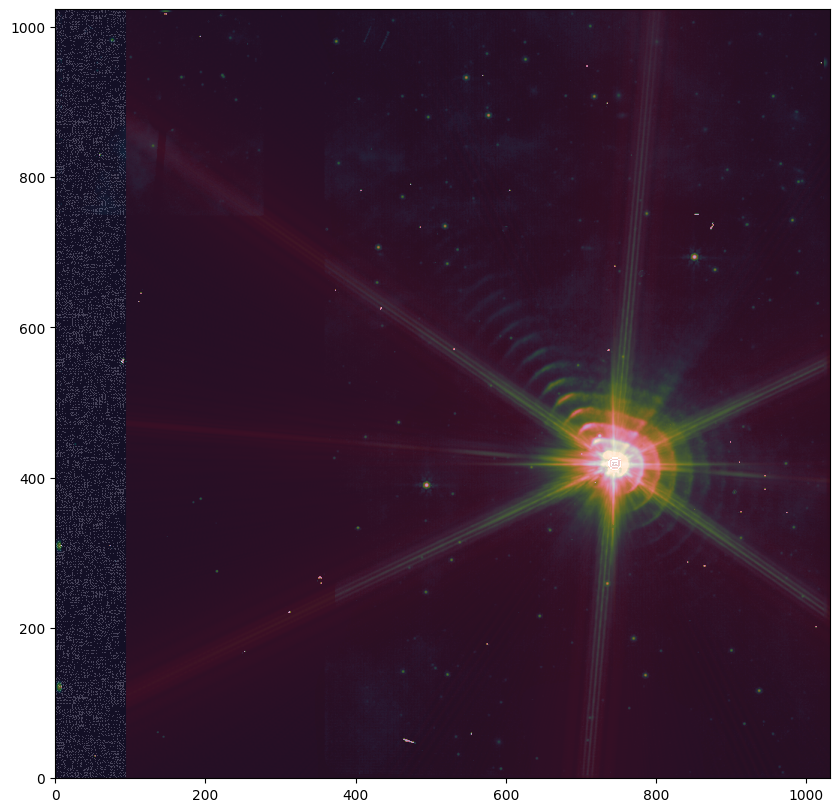

In [50]:

x_diff = cx-pcx
y_diff = cy-pcy
# x_diffw = cx-pwcx
# y_diffw = cy-pwcy
print(x_diff,y_diff)

psf_shifted = shift(norm_psf,(y_diff,x_diff)) #1550: -6, +1, #2100: -13, +3 #770: -3, +3
psf_crop = psf_shifted[0:y_shape,0:x_shape]

result_crop = result[0:y_shape,0:x_shape]

fig = plt.figure(figsize=(10,10))
plt.imshow(psf_crop , origin = "lower",cmap=psf_cmap, norm = matplotlib.colors.LogNorm(vmin, vmax))
WRplot = plt.imshow(result_crop, origin = 'lower',norm=norm, cmap = colormap, alpha = 0.8)

# plt.savefig("science_psf_overlay_F770W_stage2_c1_newcenter_"+dither+"_circlemask.pdf", dpi=300)

pixel_area = 0.0121 #arcseconds squared
pixel_width = np.sqrt(pixel_area) #arcseconds
x_shift = x_diff*pixel_width #arcseconds
y_shift = y_diff*pixel_width #arcseconds
print(x_shift,y_shift)
print(x1,x2,y1,y2)
print(np.shape(result))
# plt.close(fig)

In [55]:
print(np.max(psf))
print(np.max(result))
print(np.max(result)/np.max(psf))
# ratio = np.max(result)/np.min(psf)
half_boxsize = 15
sci_box_vals = []
psf_box_vals = []
for pix in range(len(spike_x)):
    box_x = np.arange(spike_x[pix]-half_boxsize,spike_x[pix]+half_boxsize,1)
    box_y = np.arange(spike_y[pix]-half_boxsize,spike_y[pix]+half_boxsize,1)
    sci_box_vals.append(np.mean(result[box_x,box_y]))
sci_box_vals = np.array(sci_box_vals)
mean_sci_box = np.mean(sci_box_vals)

print(np.mean(sci_box_vals))
print("Scaling pixels: "+str(list(zip(spike_x,spike_y))))
sci_spike_vals = result_crop[spike_x,spike_y]
print("Science values at scaling pixels: "+str(sci_spike_vals))
sci_pix_mean = np.mean(sci_spike_vals)
print("Mean of scaling pixel values (sci): "+str(sci_pix_mean))
psf_spike_vals = psf_crop[spike_x,spike_y]
print("PSF values at scaling pixels: "+str(psf_spike_vals))
psf_pix_mean = np.mean(psf_spike_vals)
print("Mean of scaling pixel values (sci): "+str(psf_pix_mean))
sci_scale_factors = sci_spike_vals / psf_spike_vals
print("Factors to make psf vals = sci vals: "+str(sci_scale_factors))
print("PSF scaled to Sci at spike pixels: "+str(psf_spike_vals*sci_scale_factors))

sci_scale = mean_sci_box / psf_pix_mean
print("Mean of factors to make psf vals = sci vals (final scaling factor): "+str(sci_scale))

71693.14949303883
2.748028
Scaling pixels: [(561, 758), (354, 613), (340, 867), (336, 864)]
Science values at scaling pixels: [4.7583027 5.3203535 4.663207  5.194129 ]
Mean of scaling pixel values (sci): 4.9839983
PSF values at scaling pixels: [4.74797494e-06 8.78422905e-06 5.25615994e-06 1.07771435e-05]
Mean of scaling pixel values (sci): 7.391376846330881e-06
Factors to make psf vals = sci vals: [1002175.1911494   605671.08123598  887188.95716999  481957.85921996]
PSF scaled to Sci at spike pixels: [4.75830269 5.32035351 4.66320705 5.19412899]
Mean of factors to make psf vals = sci vals (final scaling factor): 371788.38220058917


0.0015941087739843739
3547.465087890625


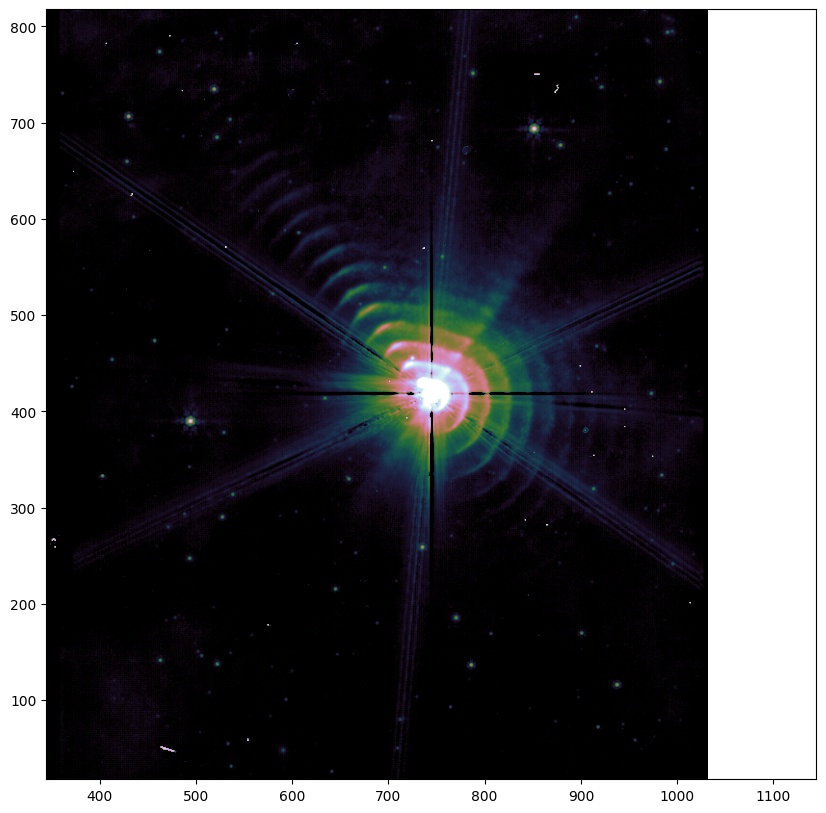

In [58]:
bdelt =400

psf_scaled = psf_crop*(sci_scale)

print(np.sum(psf_crop)/len(psf_crop))
print(np.sum(result_crop)/len(result_crop))

image_b_subPSF = result_crop - psf_scaled

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()

new_norm = simple_norm(image_b_subPSF, 'log', min_cut =  0.0, max_cut = 1000.)
ax.imshow(image_b_subPSF, origin = 'lower', norm=new_norm, cmap = colormap)

marker = '+'
ms, mew = 15, 1.0

ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

# plt.savefig("Wr140_"+filt+"_"+cycle+"_dither"+dither+"_PSFsubtracted_only3rdSliceAtLargerScale.pdf", dpi = 300)
plt.show()
plt.close(fig)

In [21]:
fits.update(filename, image_b_subPSF, header1, 'SCI')#only run if youre sure its good, this overwrites the file - always have a backup
fits.info(filename)

Filename: /Users/emmalieb/WR140Paper/pipeline_rerun_Cycle1/jw01349058001_F2100W_00012_mirimage_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     339   ()      
  1  SCI           1 ImageHDU       144   (1032, 1024)   float64   
  2  ERR           1 ImageHDU        10   (1032, 1024)   float32   
  3  DQ            1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (1032, 1024)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (1032, 1024)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (1032, 1024)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (1032, 1024)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [29842B]   
